<a id="0"></a> <br>
 # Table of Contents  
 
 1. [Inspiration](#1)     
 1. [Data Preprocessing](#2) 
 1. [Modeling Fitting and Evaluation](#3) 
    1. [ROC_AUC Curve](#4)
    1. [Model Coefficients](#5)
    1. [Confusion Matrix](#6)
    1. [ROC Curve](#7)
    1. [Plot of Precision and Recall Versus the Decision Threshold](#8)
 1.[*Template for Creating Random Undersampling (Random) PipeLine](#9)

<a id="1"></a> <br>
## Inspiration

According to the chapter 2 analysis, the dataset is extremely unbalanced, with 49736 charge-off records and 229791 Fully Paid records. As is well known, the objective of this initiative is to train a Machine Learning (ML) model to accurately detect "charge-off" cases in order to control business risk. Under such backgraound, disgarding samples of "Fully Paid" and creating a balanced dataset maybe be beneficial to training an ML alrogrithm.

There are numerous undersampling techniques, with random undersampling being the most straightforward. However, the primary disadvantage of random undersampling is that it can disregard potentially useful data that could be crucial for algorithm training. To generate a balanced data set, There are three major undersampling techniques based on https://machinelearningmastery.com/undersampling-algorithms-for-imbalanced-classification/. However, due to the limited memory of personal computers, intricate procedures will be temporarily suspended. As a demonstration for this chapter, we will use **random** undersampling to generate a balanced dataset.

* Methods that Select Examples to Keep
  - Random Undersampling 
  - Near Missing(NM) Undersampling
  - Conddensed Nearest Neighbor Rule (CNNR) for Undersampling
 
* Methods that select Examples to Delete
  - Tomek Links (TL) for Undersampling
  - Edited Nearest Neighbors Rule (ENNR) for Undersampling

* Combinations of Keep and Delete Methods
  - One-Sided Selection (OSS) for Undersampling
  - Neighborhood Cleaning Rule (NCR) for Undersampling
  


<a id="2"></a> <br>
 ## Package Set up and Data Input

In [1]:
import os
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score,  roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn import metrics
from sklearn.metrics import classification_report

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

#import matplotlib.pyplot as plt
#bimport seaborn as sns

import imblearn
from imblearn.under_sampling import RandomUnderSampler
#from imblearn.under_sampling import CondensedNearestNeighbour
#from imblearn.pipeline import Pipeline as imbPipeline

%run functions.ipynb

In [2]:
data = pd.read_csv("../Data/data_selected.csv")
data = pd.DataFrame(data)
data = data.dropna() # drop na
data.isnull().sum() # check the na

Unnamed: 0              0
loan_status             0
term                    0
grade                   0
emp_length              0
home_ownership          0
verification_status     0
purpose                 0
addr_state              0
initial_list_status     0
application_type        0
loan_amnt               0
int_rate                0
installment             0
annual_inc              0
dti                     0
open_acc                0
pub_rec                 0
revol_util              0
total_acc               0
mort_acc                0
pub_rec_bankruptcies    0
last_fico_range_low     0
last_fico_range_high    0
dtype: int64

In [3]:
data["loan_status"].value_counts()

Fully Paid     919547
Charged Off    198560
Name: loan_status, dtype: int64

In [4]:
# covert catergocial to dummy, treat charged off as positive instance
loan_status = pd.get_dummies(data["loan_status"])
data["loan_status"] = loan_status["Charged Off"] # 0-full paid, 1-charged off 
data

,Unnamed: 0,loan_status,term,grade,emp_length,home_ownership,verification_status,purpose,addr_state,initial_list_status,...,annual_inc,dti,open_acc,pub_rec,revol_util,total_acc,mort_acc,pub_rec_bankruptcies,last_fico_range_low,last_fico_range_high
0,0,0,36 months,C,10+ years,MORTGAGE,Not Verified,debt_consolidation,PA,w,...,55000.0,5.91,7.0,0.0,29.7,13.0,1.0,0.0,560.0,564.0
1,1,0,36 months,C,10+ years,MORTGAGE,Not Verified,small_business,SD,w,...,65000.0,16.06,22.0,0.0,19.2,38.0,4.0,0.0,695.0,699.0
2,2,0,60 months,B,10+ years,MORTGAGE,Not Verified,home_improvement,IL,w,...,63000.0,10.78,6.0,0.0,56.2,18.0,5.0,0.0,700.0,704.0
3,4,0,60 months,F,3 years,MORTGAGE,Source Verified,major_purchase,PA,w,...,104433.0,25.37,12.0,0.0,64.5,35.0,6.0,0.0,700.0,704.0
4,5,0,36 months,C,4 years,RENT,Source Verified,debt_consolidation,GA,w,...,34000.0,10.20,5.0,0.0,68.4,6.0,0.0,0.0,755.0,759.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1187924,2260685,1,60 months,C,5 years,RENT,Verified,credit_card,CA,f,...,95000.0,21.50,11.0,0.0,79.8,24.0,6.0,0.0,550.0,554.0
1187925,2260686,0,60 months,C,10+ years,MORTGAGE,Not Verified,debt_consolidation,OH,f,...,119000.0,32.73,13.0,0.0,89.5,29.0,5.0,0.0,675.0,679.0
1187926,2260688,0,60 months,B,5 years,OWN,Not Verified,home_improvement,TX,f,...,130000.0,20.59,17.0,0.0,34.0,39.0,3.0,0.0,705.0,709.0
1187927,2260690,0,60 months,C,9 years,MORTGAGE,Not Verified,debt_consolidation,CA,f,...,180792.0,22.03,16.0,0.0,85.2,32.0,3.0,0.0,715.0,719.0


<a id="2"></a> <br>
## Data Preprocessing

In [5]:
y = data.loan_status
X = data.drop(["loan_status", 'Unnamed: 0'], axis =1)

X_under, y_under = RandomUnderSampler().fit_resample(X,y)

X_train, X_test, y_train, y_test = train_test_split(X_under, y_under, random_state = 666, test_size = 0.25, shuffle = True)

In [29]:
# save undersampled data to csv file
#data_undersampled = X_under.copy()
#data_undersampled["loan_status"] = y_under
#data_undersampled.to_csv("../Data/data_selected_undersampled.csv", header = True, index = False)

In [6]:
y_train.value_counts()

1    148973
0    148867
Name: loan_status, dtype: int64

In [7]:
y_test.value_counts()

0    49693
1    49587
Name: loan_status, dtype: int64

In [8]:
numeric_features = ['int_rate',
       'installment', 'annual_inc', 'dti', 'open_acc', 'pub_rec', 'revol_util',
       'total_acc', 'mort_acc', 'pub_rec_bankruptcies', 'last_fico_range_low',
       'last_fico_range_high']
categorical_features = ['term', 'grade', 'emp_length',
       'home_ownership', 'verification_status', 'purpose', 'addr_state',
       'initial_list_status', 'application_type']

In [9]:
categorical_transformer = Pipeline(steps =[
    ('onehot',OneHotEncoder(drop = "first"))
])

numeric_transformer = Pipeline(steps =[
    ("scale", StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers = [
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

In [10]:
log_model = LogisticRegression(solver = "lbfgs", max_iter = 500)
pipeline = Pipeline(steps = [
    ("preprocessor", preprocessor),
    ("log_model", log_model)
])

<a id="3"></a> <br>
## Model fitting and Evaluation

In [11]:
fitted_pipeline = pipeline.fit(X_train, y_train)

<a id="4"></a> <br>
## ROC_AUC score

In [12]:
y_train_pred = fitted_pipeline.predict(X_train)
y_test_pred = fitted_pipeline.predict(X_test)


train_auc = roc_auc_score(y_train, y_train_pred)
test_auc = roc_auc_score(y_test, y_test_pred)

In [13]:
print("train_auc: ", round(train_auc,4),"test_auc: ", round(test_auc,4))

train_auc:  0.8937 test_auc:  0.8939


<a id="5"></a> <br>
## Model Coefficents

In [16]:
cat_onehot = pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(input_features = categorical_features)
col_names = list(numeric_features)+list(cat_onehot)
all_col_names = ['Constant']+col_names
all_coef = np.hstack((log_model.intercept_[0],log_model.coef_[0]))
model_coef = pd.DataFrame({'features':all_col_names,'coef':all_coef,})

In [17]:
model_coef

,features,coef
0,Constant,-0.243154
1,int_rate,0.034296
2,installment,0.363665
3,annual_inc,-0.129011
4,dti,0.190557
...,...,...
95,addr_state_WI,0.133323
96,addr_state_WV,-0.112633
97,addr_state_WY,-0.019308
98,initial_list_status_w,-0.026997


<a id="6"></a> <br>
### Confusion Matrix

In [18]:
cnf_matrix = metrics.confusion_matrix(y_test,y_test_pred)
cnf_matrix

array([[44400,  5293],
       [ 5244, 44343]])

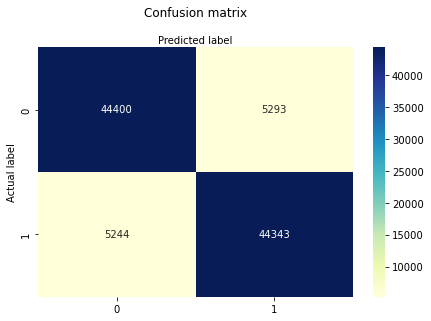

In [19]:
confusion_metrix_vis(cnf_matrix)

In [21]:
target_names = ['Fully Paid','Charge-off']
print(classification_report(y_test, y_test_pred, target_names=target_names))

              precision    recall  f1-score   support

  Fully Paid       0.89      0.89      0.89     49693
  Charge-off       0.89      0.89      0.89     49587

    accuracy                           0.89     99280
   macro avg       0.89      0.89      0.89     99280
weighted avg       0.89      0.89      0.89     99280



<a id="7"></a> <br>
### ROC_Curve

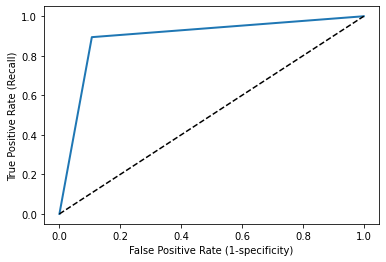

In [23]:
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
plot_roc_curve(fpr,tpr)

<a id="8"></a> <br>
### Plot of Precision and Recall Versus the Decision Threshold

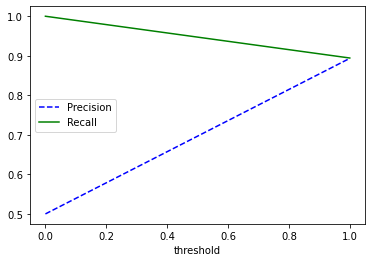

In [25]:
precisions, recalls, thresholds = precision_recall_curve(y_test, y_test_pred)
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

<a id="9"></a> <br>
## *Template for Creating Random Undersampling (Random) PipeLine

In [42]:
#random_undersampling = RandomUnderSampler()
#log_model = LogisticRegression(solver = "lbfgs", max_iter = 500)

#pipeline_random = imbPipeline(steps = [
#    ("preprocessor", preprocessor),
#    ("random", random_undersampling),
#    ("log_model", log_model)
#])

In [43]:
#cv = RepeatedStratifiedKFold(n_splits = 2, n_repeats = 1, random_state = 666)
#scores_random = cross_val_score(pipeline_random, X, y, scoring="recall", cv = cv, n_jobs = -1)

In [44]:
#print("Recall for Random Undersampling Method: ", round(np.nanmean(scores_random),4))